In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import wradlib
import glob
from scipy import stats, linspace
import scipy as sp
import wradlib as wrl
from osgeo import osr
from pcc import get_time_of_gpm

from pcc import get_my_cmap
my_cmap2 = get_my_cmap()
import datetime as dt

% matplotlib inline 


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [2]:
def ipoli_radi(gr_grid, gr_data,sr_grid,radius):
    """

    Parameters
    ----------
    gr_grid ::: grid of the Ground Radar
    gr_data ::: data of the Ground Radar
    sr_grid ::: grid oft the Spaceborn Radar
    radius  ::: radius of the dpr foot prints


    Returns
    -------
    gs_grid ::: Interpolated Groundradar Data on Spaceborne Grid

    """

    gr_ipoli_data = np.zeros((sr_grid.shape[0]))

    for i in range(sr_grid.shape[0]):
        
        # set x_0 and y_0
        x0, y0 = sr_grid[i,0], sr_grid[i,1] 
        
        # calc radius for all other points
        rr = np.sqrt((gr_grid[:,0] - x0)**2 + (gr_grid[:,1] - y0)**2)
        
        # check if footptint 
        if gr_data[rr < radius].size!=0:
            # if not empty calc mean
            gr_ipoli_data[i] = np.nanmean(gr_data[rr < radius])
        
        else:
            # if empty set NAN
            gr_ipoli_data[i] = np.nan


    return gr_ipoli_data

In [3]:
def write2hdf(name, x, y, dpr_pp, dpr_bbh, dpr_bbw, dpr_type,
                   dpr_phase, dpr_sth, dpr_cfb,dpr_lst, dpr_ele,
              radolan_ry, radolan_rhmax, radolan_rhmin):
    """wip"""
    h = h5py.File(str(name) + '.hdf5', 'w')
    h.create_dataset('x', data=x)
    h.create_dataset('y', data=y)
    h.create_dataset('sr_pp', data=dpr_pp)
    h.create_dataset('sr_bbh', data=dpr_bbh)
    h.create_dataset('sr_bbw', data=dpr_bbw)
    h.create_dataset('sr_phase', data=dpr_phase)
    h.create_dataset('sr_type', data=dpr_type)
    h.create_dataset('sr_sth', data=dpr_sth)
    h.create_dataset('sr_cfb', data=dpr_cfb)
    h.create_dataset('sr_lst', data=dpr_lst)
    h.create_dataset('sr_ele', data=dpr_ele)
    h.create_dataset('gr_ry', data=radolan_ry)
    h.create_dataset('gr_rh_max', data=radolan_rhmax)
    h.create_dataset('gr_rh_min', data=radolan_rhmin)

    h.close()

In [4]:
def idx_sr_in_gr_area(_bingrid, _gpm_xy):
    """
    Funktion:
    ---------
    Search for SR Footprint (Index) that are located in the GR scan area 
    
    Input: 
    ------
    bingrid ::: Binary-grid of the GR scan area
        
    
    Output:
    -------
    
    """
    _gpm_xy = _gpm_xy.copy()
    # Bestimmen von Eckpunkten bei RADOLAN RY GRID!
    # HARDCODED: but ok for regula RADOLAN Produkts
    xmin, xmax = -523.4621669218559, 375.5378330781441
    ymin, ymax = -4658.644724265572, -3759.644724265572
    
    # Radolangitter um 1 gridpoit zu allen seiten erweitern
    _xex, _yex = np.arange(xmin-1, xmax+2, 1), np.arange(ymin-1, ymax+2, 1)
    _xxx, _yyy = np.meshgrid(_xex,_yex)
    
    # Bin grid bestimmen
    _bingrid = _bingrid.copy()
    _bingrid[_bingrid >= 0]=1
    _bingrid[_bingrid < 0]=0
    
    # Gittererweiterungen zusammenstellen
    ## rn_tb ::: bin gird top and bottom
    ## rn_lr ::: bin gird left and right
    rn_tb = np.zeros(900)
    rn_lr = np.zeros(902)
    
    # Griderweiterungen einsetzen
    # erst oben und unten
    rn1 = np.c_[rn_tb, _bingrid, rn_tb]
    # dann rechts
    rn2 = np.vstack((rn1, rn_lr))
    # dann rechts
    rn3 = np.vstack((rn_lr,rn2))
    
    from skimage import measure
    # Contouren des Bin-grids erstellen
    contours = measure.find_contours(rn3, 0, positive_orientation='high',
                                     fully_connected='high' )

    # bestiimung der Listen für Polygon Points
    _xx = []
    _yy = []

    # suche nach dem größten Polygon... dieser sollte der RADOLAN UMRISS sein
    for i in range(len(contours)):
        # Polygone mit 3 oder weniger points ergeben keine nutzbare Fläche
        if len(_xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)]) <= 3:
            print('not relevant polygon')
        else:   
            # PolygonPoints bestimmen (RADOLAN RAND POINTS)
            ########################## Ist hier ein Fehler ? ????????????????????????????????????
            _xx.append(_xxx[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            _yy.append(_yyy[contours[i][:,0].astype(int),contours[i][:,1].astype(int)])
            
    # sortiern nach der länge, das letzt element ist das größte und sollte somit der Radolarand sein
    _xx.sort(key=len)
    _yy.sort(key=len)

    # Outter polygon erstellen
    _xy = np.vstack((_xx[-1].ravel(), _yy[-1].ravel())).transpose()    
    
    
    # Suche nach den GPM footprints im Scanngebiet von RADOLAN mit ZONALSTATS
    zdpoly = wradlib.zonalstats.ZonalDataPoly(_gpm_xy, [_xy])
    _gpm_xy_outer_idx = zdpoly.get_source_index(0)
    

    _gpm_xy_inner_idx = np.array([])
    # Entferne Inner Polygons
    # Auch nur wenn es weitere Polygone gibt 
    if len(_xx)>1:

        for inner_poly_index in range(len(_xx)-1):

            print ('Polygon size: ', len(_xx[inner_poly_index].ravel()))

            _xy_inner = np.vstack((_xx[inner_poly_index].ravel(),
                                  _yy[inner_poly_index].ravel())).transpose()

            _zdpoly = wradlib.zonalstats.ZonalDataPoly(_gpm_xy, [_xy_inner])

            _inner_idx = _zdpoly.get_source_index(0)

            np.append(_gpm_xy_inner_idx, _inner_idx)


            if _gpm_xy_inner_idx.size==0:
                print ('inner polygons do not match with SR grid')

            else:
                print('match idx with inner polygon: ', _gpm_xy_inner_idx.shape)
                    

        
    return _gpm_xy_outer_idx, _gpm_xy_inner_idx 
        

## Richtige schnelle Interpolation
---------------------------------------


In [45]:
zz = np.array(['20141008'])
t1 = dt.datetime.now()


for i in range(len(zz)):
    ZP = str(zz[i])
    #year, m, d, ht, mt, st = ZP[0:4], ZP[4:6], ZP[6:8], ZP[8:10], ZP[10:12], ZP[12:14]
    year, m, d = ZP[0:4], ZP[4:6], ZP[6:8]

    ye = ZP[2:4]

    
    ## Read GPM Data
    ## -------------
    pfad_gpm = glob.glob("/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308."
                           +str(year)+str(m)+str(d)+"*.HDF5")[0]
    gpmdpr = h5py.File(pfad_gpm, 'r')
    sc = 'NS'
    
    
    # GPM navigation and tim
    lat = np.array(gpmdpr[sc]['Latitude'])
    lon = np.array(gpmdpr[sc]['Longitude'])
    
    # Clip GPM Swath Region
    poly = [[4., 47.], [4., 54.], [15., 54.], [15., 47.], [4., 47.]]
    
    mask = wrl.zonalstats.get_clip_mask(np.dstack((lon[:], lat[:])), poly)
    mask = np.nonzero(np.count_nonzero(mask, axis=1))
    gpm_lat = lat[mask]
    gpm_lon = lon[mask]
    
    gpm_time = gpmdpr[sc]['ScanTime']
    gpm_zeit = get_time_of_gpm(lon, lat, gpm_time)

    ht, mt = gpm_zeit[14:16], str(int(round(float(gpm_zeit[17:19])/5.0)*5.0))
    if mt == '0':
        mt = '00'
    elif mt == '5':
        mt = '05'

    print gpm_zeit
    # Precipitation
    dpr_pns = np.array(gpmdpr[sc]['SLV']['precipRateESurface'])[mask]
    dpr_pns[dpr_pns ==-9999.9]= np.nan
    # Reflectivity
    #dpr_ref = np.array(gpmdpr[sc]['SLV']['zFactorCorrectedESurface'])
    #dpr_ref[dpr_ref < 0] = np.nan
    # Bright-band height
    dpr_bbh = np.array(gpmdpr[sc]['CSF']['heightBB'], dtype=float)[mask]
    dpr_bbh[dpr_bbh < 0] = np.nan
    # Bright-band width
    dpr_bbw = np.array(gpmdpr[sc]['CSF']['widthBB'], dtype=float)[mask]
    dpr_bbw[dpr_bbw < 0] = np.nan
    # PhaseNearSurface
    dpr_pha = np.array(gpmdpr[sc]['SLV']['phaseNearSurface'], dtype=int)[mask]
    dpr_pha = dpr_pha/100
    #dpr_phase[dpr_phase==255]=np.nan
    #typePrecip
    dpr_typ = np.array(gpmdpr[sc]['CSF']['typePrecip'], dtype=float)[mask]
    #StromTopHeight
    dpr_sth = np.array(gpmdpr[sc]['PRE']['heightStormTop'], dtype=float)[mask]
    dpr_sth[dpr_sth < 0] = np.nan
    #Elevation
    dpr_ele = np.array(gpmdpr[sc]['PRE']['elevation'], dtype=float)[mask]
    dpr_ele[dpr_ele == -9999] = np.nan
    #Clutterfreebottom
    dpr_cfb = np.array(gpmdpr[sc]['PRE']['binClutterFreeBottom'], dtype=float)[mask]
    # Landsurfacetyp
    dpr_lst = np.array(gpmdpr[sc]['PRE']['landSurfaceType'])[mask]
    

    ## GPM Koordinaten in dwd_radolan_kartesisch
    ## ----------------------------------------------
    proj_stereo = wrl.georef.create_osr("dwd-radolan")
    proj_wgs = osr.SpatialReference()
    proj_wgs.ImportFromEPSG(4326)

    gpm_x, gpm_y = wradlib.georef.reproject(gpm_lon, gpm_lat,
                                            projection_target=proj_stereo,
                                            projection_source=proj_wgs)
    
    
    ## Read RADOLAN Data
    ## -----------------
    r_pro = 'ry'

    pfad = ('/automount/radar/dwd/'+ r_pro +'/'+str(year)+'/'+str(year)+'-'+
            str(m)+'/'+ str(year)+'-'+str(m)+'-'+str(d)+'/raa01-'+r_pro+'_10000-'+
            str(ye)+str(m)+ str(d)+str(ht)+str(mt)+'-dwd---bi*')


    rwdata, rwattrs = wradlib.io.read_RADOLAN_composite(glob.glob(pfad)[0])

    radolan_zeit = rwattrs['datetime'].strftime("%Y.%m.%d -- %H:%M:%S")


    radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
    x = radolan_grid_xy[:,:,0]
    y = radolan_grid_xy[:,:,1]
    rwdata = np.ma.masked_equal(rwdata, -9999) *8#/ 2 - 32.5
    
    bingrid = rwdata.copy()
    
    # GPM Koordinaten revelen 
    gpm_xy = np.vstack((gpm_x.ravel(), gpm_y.ravel())).transpose()
    
    outer_idx, inner_idx = idx_sr_in_gr_area(bingrid, gpm_xy)
    
    gpm_pns = dpr_pns.ravel()[outer_idx]
    gpm_bbh = dpr_bbh.ravel()[outer_idx]
    gpm_bbw = dpr_bbw.ravel()[outer_idx]
    gpm_pha = dpr_pha.ravel()[outer_idx]
    gpm_typ = dpr_typ.ravel()[outer_idx]
    gpm_ele = dpr_ele.ravel()[outer_idx]
    gpm_lst = dpr_lst.ravel()[outer_idx]
    gpm_cfb = dpr_cfb.ravel()[outer_idx]
    gpm_sth = dpr_sth.ravel()[outer_idx]

    gpm_xy = gpm_xy[outer_idx]

    # ToDo: Implement inner_idx_polygons
    #if inner_idx.size!=0:
    #    gpm_pns[]????
    
    ## Read RADOLAN Altitudes
    ## ----------------------
    
    rhmax = np.load("/automount/ags/velibor/data/radolan_dx/RY_maxHxy_b2017.npy")[2]
    rhmin = np.load("/automount/ags/velibor/data/radolan_dx/RY_minHxy_b2017.npy")[2]
    
    
    rwd = rwdata.copy()
    th_rr = 0.5
    rwdata = rwdata[rwd > th_rr]
    x = x[rwd > th_rr]
    y = y[rwd > th_rr]
    rhmax = rhmax[rwd > th_rr]
    rhmin = rhmin[rwd > th_rr]
    
    ## INTERLOLATION
    ## --------------
    gk3 = wradlib.georef.epsg_to_osr(31467)

    xy = np.vstack((x.ravel(), y.ravel())).transpose()
    
    # dpr footprint 5.2
    # eigentlich DPR Alt abhängig
    dpr_footprint = 5.0
    
    result = ipoli_radi(xy, rwdata.ravel().filled(np.nan),gpm_xy, dpr_footprint - 0.5)
    
    res_h_max = ipoli_radi(xy, rhmax.ravel(),gpm_xy, dpr_footprint - 0.5)
    res_h_min = ipoli_radi(xy, rhmin.ravel(),gpm_xy, dpr_footprint - 0.5)
    
    rrr = np.ma.masked_invalid(result)

    #rrr = result.reshape(gpm_x.shape)

    gpm_pns[gpm_pns<=0.5]=np.nan
    rrr[rrr<=0.5]=np.nan
    
    ggg = gpm_pns
    
    ## Write and save to HDF5 file
    ## ----------------------------
    name = '/automount/ags/velibor/gpmdata/dumpdataV7/' \
                       'dprrado_'+sc+'/dprrado_'+ sc + str(gpm_zeit)

    write2hdf(name, gpm_xy[:,0], gpm_xy[:,1], ggg,
              gpm_bbh, gpm_bbw, gpm_typ,
              gpm_pha, gpm_sth, gpm_cfb,
              gpm_lst, gpm_ele, rrr,res_h_max,res_h_min)

    print '/automount/ags/velibor/gpmdata/dumpdataV7/SKILL_'+sc+ str(gpm_zeit)
    
print('ende') 
t2 = dt.datetime.now()
print(t2-t1)  

2014.10.08 -- 01:42:33
('Polygon size: ', 5)
inner polygons do not match with SR grid
('Polygon size: ', 70)
inner polygons do not match with SR grid
/automount/ags/velibor/gpmdata/dumpdataV7/SKILL_NS2014.10.08 -- 01:42:33
ende
0:00:14.434939


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:161: RuntimeWarning: invalid value encountered in less_equal


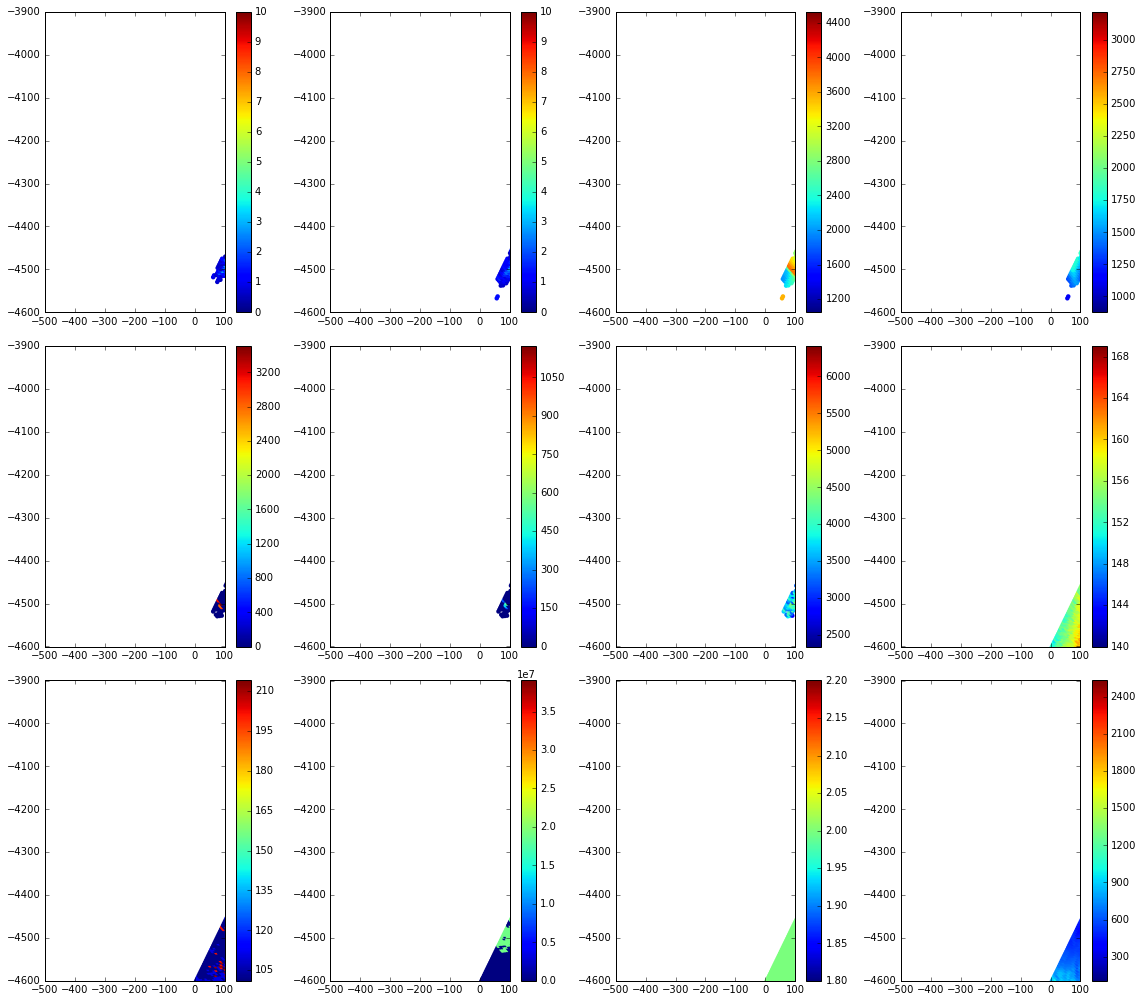

In [46]:
plt.figure(figsize=(16,14))
plt.subplot(3,4,1)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=ggg
            , edgecolors='none', vmin=0, vmax=10)
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,2)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=rrr
            , edgecolors='none', vmin=0, vmax=10)
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,3)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=res_h_max
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,4)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=res_h_min
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,5)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_bbh
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,6)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_bbw
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,7)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_sth
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,8)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_cfb
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,9)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_lst
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,10)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_typ
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,11)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_pha
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.subplot(3,4,12)
plt.scatter(gpm_xy[:,0], gpm_xy[:,1], c=gpm_ele
            , edgecolors='none')
plt.colorbar()
plt.xlim(-500,100); plt.ylim(-4600,-3900)

plt.tight_layout()
plt.show()

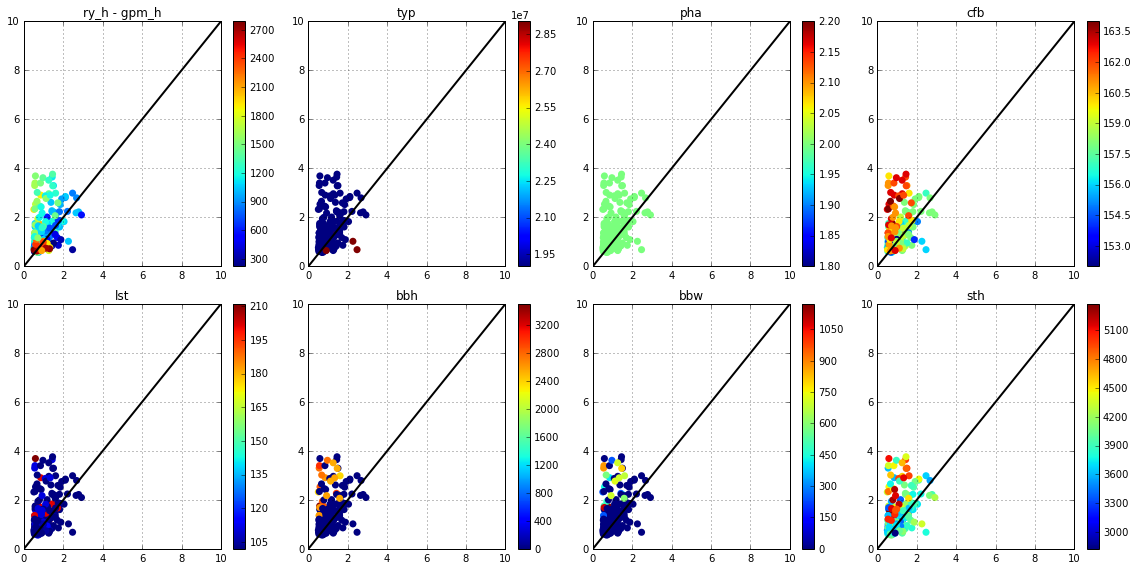

In [49]:
plt.figure(figsize=(16,8))

plt.subplot(2,4,1)
plt.scatter(ggg,rrr,c=res_h_min-gpm_ele, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('ry_h - gpm_h')


plt.subplot(2,4,2)
plt.scatter(ggg,rrr,c=gpm_typ, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('typ')


plt.subplot(2,4,3)
plt.scatter(ggg,rrr,c=gpm_pha, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('pha')


plt.subplot(2,4,4)
plt.scatter(ggg,rrr,c=gpm_cfb, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('cfb')


plt.subplot(2,4,5)
plt.scatter(ggg,rrr,c=gpm_lst, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('lst')


plt.subplot(2,4,6)
plt.scatter(ggg,rrr,c=gpm_bbh, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('bbh')


plt.subplot(2,4,7)
plt.scatter(ggg,rrr,c=gpm_bbw, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.grid()
plt.title('bbw')


plt.subplot(2,4,8)
plt.scatter(ggg,rrr,c=gpm_sth, edgecolors='none', s=50)
plt.colorbar()
plt.xlim(0,10); plt.ylim(0,10)
plt.plot([0,10],[0,10], color='black', lw=2)
plt.title('sth')
plt.grid()


plt.tight_layout()
plt.show()
